In [2]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import pandas as pd 
import numpy as np 
from tqdm import tqdm

from PIL import Image
#from tensorflow import keras

import tensorflow as tf
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation, LSTM, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate as con
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

import os

/Users/aparnakane/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
label_map = {
    0:"Nucleoplasm",
    1:"Nuclear membrane",  
    2:"Nucleoli",   
    3:"Nucleoli fibrillar center",
    4:"Nuclear speckles",
    5:"Nuclear bodies",
    6:"Endoplasmic reticulum",
    7:"Golgi apparatus",  
    8:"Peroxisomes",
    9:"Endosomes",   
    10:"Lysosomes", 
    11:"Intermediate filaments",
    12:"Actin filaments",
    13:"Focal adhesion sites",
    14:"Microtubules",
    15:"Microtubule ends",
    16:"Cytokinetic bridge",
    17:"Mitotic spindle",  
    18:"Microtubule organizing center",  
    19:"Centrosome",
    20:"Lipid droplets",
    21:"Plasma membrane",
    22:"Cell junctions",
    23:"Mitochondria",
    24:"Aggresome",
    25:"Cytosol",
    26:"Cytoplasmic bodies",
    27:"Rods & rings"

}

In [37]:
MAIN_DIR = os.path.join(os.getcwd(),"Proteins")
TRAIN_DIR = MAIN_DIR + "/train"
TEST_DIR = MAIN_DIR + "/test"
LABELS = MAIN_DIR+ "/train.csv"

In [38]:
n_classes = 28
batch_size = 12

In [39]:
data = pd.read_csv(LABELS)

In [6]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(TRAIN_DIR, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)


In [16]:
# https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379
class datagenerator:
    
    def create_train(dataset_info, batch_size, shape, augment=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = datagenerator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augment:
                        image = datagenerator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        np.array(image_red_ch), 
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [8]:
train_indexes, valid_indexes = train_test_split(np.arange(train_dataset_info.shape[0]), test_size=0.3, random_state=8)

In [10]:
train_gen = datagenerator.create_train(train_dataset_info[train_indexes],64,(224,224,3),augment = True )
valid_gen= datagenerator.create_train(train_dataset_info[valid_indexes], 32, (224,224,3),augment =False)

In [11]:
 pics = datagenerator.create_train(train_dataset_info, 5, (224,224,3), augment = False)

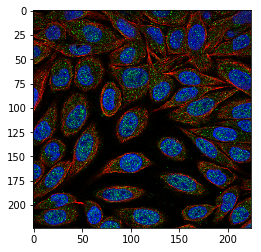

In [12]:
pic = datagenerator.load_image(TRAIN_DIR+ "/0038d6a6-bb9a-11e8-b2b9-ac1f6b6435d0", (224,224,1))
plt.imshow(pic)

In [13]:
K.image_data_format()

'channels_last'

In [14]:
model1 = Sequential()
model1.add(TimeDistributed(Conv2D(32,64, 
                                 padding = 'same', 
                                 activation = 'relu', 
                                 input_shape = (224,224,3), 
                                 data_format="channels_last" )))
model1.add(TimeDistributed(MaxPooling2D(32,strides=2)))
model1.add(TimeDistributed(Conv2D(64,32,strides = 5, padding='same',activation='relu')))
model1.add(TimeDistributed(MaxPooling2D(16,strides=2)))
model1.add(TimeDistributed(Flatten()))
model1.add(TimeDistributed(Dense(64)))

model1.add(LSTM(64, return_sequences=True))
model1.add(Dense(n_classes))

model1.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])



Instructions for updating:
Colocations handled automatically by placer.


In [15]:
input_shape = (224,224,3)


# Base model taken from https://github.com/qjadud1994/CRNN-Keras/blob/master/Model.py#L5
inputs = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)
      # Convolution layer (VGG)
inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  
inner = Dropout(0.25)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  
inner = Dropout(0.25)(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv6', kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max3')(inner)
inner = Dropout(0.25)(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv8', kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv9')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max4')(inner)
inner = Dropout(0.25)(inner)

inner = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='con11')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='con12')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='con13')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max5')(inner) 
inner = Dropout(0.25)(inner)


    # CNN to RNN
inner = tf.keras.layers.Reshape(target_shape=((7, 512*7)), name='reshape')(inner)  
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
inner = Dropout(0.3)(inner)

    # RNN layer
lstm_1 = LSTM(256, return_sequences=False, kernel_initializer='he_normal', name='lstm1')(inner)
lstm_1b = LSTM(256, return_sequences=False, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
reversed_lstm_1b = tf.keras.layers.Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

lstm1_merged = tf.keras.layers.add([lstm_1, reversed_lstm_1b])  
lstm1_merged = BatchNormalization()(lstm1_merged)

inner = Dense(28, kernel_initializer = 'he_normal',name='dense')(lstm1_merged)
inner = BatchNormalization()(inner)
finalPred = Activation('sigmoid')(inner)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model = Model(inputs=inputs, outputs= finalPred )

In [17]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [18]:
from sklearn.metrics import f1_score

model.compile(optimizer=Adam( lr=0.001, decay=1e-6), loss='binary_crossentropy',
              metrics=['accuracy',f1])

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 224, 224, 64) 1792        the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 224, 224, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
max1 (MaxP

In [21]:
np.ceil(len(train_indexes) // 64)

339.0

In [22]:
model.reset_states()

In [23]:
filepath = "CNNLSTM-WPW.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callback =  ReduceLROnPlateau(monitor='val_f1', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)

hist = model.fit_generator(
    generator = train_gen, 
    steps_per_epoch=len(train_indexes) // 64, 
    epochs=10, 
    verbose=1,
    validation_data=valid_gen,
    validation_steps = 8 ,
    callbacks = [ callback, checkpoint]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8/8 [==============================] - 22s 3s/step - loss: 0.6257 - acc: 0.5985 - f1: 0.0952

Epoch 00001: val_acc improved from -inf to 0.59849, saving model to CNNLSTM-WPW.hdf5
339/339 [==============================] - 8977s 26s/step - loss: 0.6872 - acc: 0.6194 - f1: 0.0967 - val_loss: 0.6257 - val_acc: 0.5985 - val_f1: 0.0952
Epoch 2/10
8/8 [==============================] - 21s 3s/step - loss: 0.4946 - acc: 0.9037 - f1: 0.0990

Epoch 00002: val_acc improved from 0.59849 to 0.90374, saving model to CNNLSTM-WPW.hdf5
339/339 [==============================] - 8957s 26s/step - loss: 0.5266 - acc: 0.8708 - f1: 0.1012 - val_loss: 0.4946 - val_acc: 0.9037 - val_f1: 0.0990
Epoch 3/10
8/8 [==============================] - 27s 3s/step - loss: 0.3901 - acc: 0.9383 - f1: 0.1021

Epoch 00003: val_acc improved from 0.90374 to 0.93834, saving model to CNNLSTM-WPW.hdf5
339/339 [==============================] - 10577s 31s/step - loss: 0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


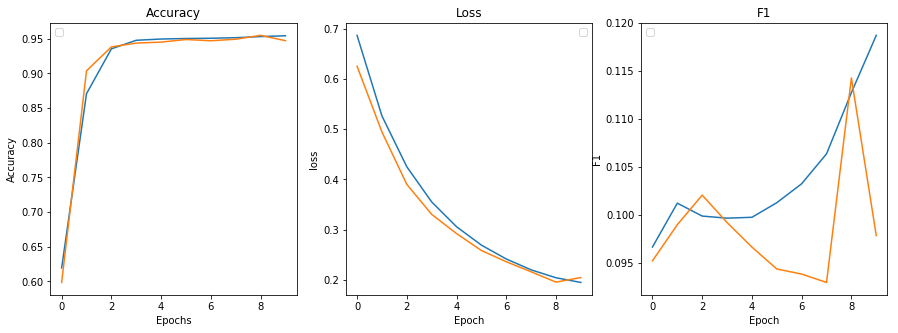

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Accuracy')
#ax[0].xlabel('Epoch')
#ax[0].ylabel('Accuracy')
ax[0].plot(hist.history['acc'])
ax[0].plot(hist.history['val_acc'])
ax[0].set(xlabel="Epochs",ylabel='Accuracy')
ax[1].set_title('Loss')
#ax[1].ylabel('Loss')
#ax[1].xlabel('Epoch')
ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set(xlabel='Epoch',ylabel='loss')

ax[2].set_title('F1')
#ax[2].ylabel('F1 Score')
#ax[2].xlabel('Epoch')
ax[2].plot(hist.history['f1'])
ax[2].plot(hist.history['val_f1'])
ax[2].set(xlabel='Epoch',ylabel='F1')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.savefig('CNN-LSTM_PROTNES.png')

In [33]:
preds = model.predict_generator(valid_gen, steps = len(valid_indexes) //32, verbose = 1)


291/291 [==============================] - 747s 3s/step


In [35]:
preds[4]

array([0.02897564, 0.09177625, 0.11881834, 0.10526374, 0.0723716 ,
       0.10751939, 0.15661445, 0.14135632, 0.10208842, 0.10029972,
       0.10081872, 0.17843804, 0.11564475, 0.11499482, 0.21003574,
       0.10018915, 0.10551655, 0.10870022, 0.11699772, 0.13236493,
       0.105259  , 0.18929678, 0.11007851, 0.10766855, 0.10752463,
       0.29705906, 0.1041798 , 0.09891635], dtype=float32)

In [40]:
predictions=[]
filenames = []
for i in range(len(preds)):
    filenames.append(train_dataset_info[i]['path'])
columns=list(label_map.keys())
for i in range(len(preds)):
    l=[]
    for j in range(len(preds[i])):
        if preds[i][j] >= 0.5:
            l.append(preds[i][j])
        else:
            l.append(0)
    predictions.append(l)
            
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["path"]=filenames
ordered_cols=["path"]+columns
results=results[ordered_cols]#To get the same column order
print(results)
results.to_csv("CNN_LSTM_PRTOEINS_results.csv",index=False)

                                                   path         0  1  \
0     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.911324  0   
1     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
2     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
3     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
4     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
5     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.783092  0   
6     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
7     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.792947  0   
8     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
9     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
10    /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.847696  0   
11    /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
12    /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.00000

In [38]:
count = 0
for i in range(len(preds)):
    for j in range(len(preds[i])):
        if preds[i][j] >= 0.5:
            count += 1

In [39]:
count 

6917

In [5]:
yeet = pd.read_csv("CNN_LSTM_PRTOEINS_results.csv")
cnn = pd.read_csv("CNN_PRTOEINS_results.csv")

In [6]:
yeet.head(25)

,path,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.911324,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0
1,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0
2,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.52101,0,0.0,0,0.000000,0,0
3,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0
4,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0
5,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.783092,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0
6,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0
7,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.792947,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.60419,0,0.0,0,0.000000,0,0
8,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0
9,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.0,0.0,0,0,0,0.000000,0,...,0,0,0,0.00000,0,0.0,0,0.000000,0,0


In [7]:
cnn.head(25)

,path,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.000000,0,0
1,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.553367,0,0
2,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.000000,0,0
3,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.000000,0,0
4,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.881025,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.000000,0,0
5,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.592991,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.813690,0,0
6,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.893525,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.000000,0,0
7,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.000000,0,0
8,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.778810,0,0.000000,0.000000,0.000000,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.774518,0,0
9,/home/paperspace/fastai/focus/Pics/Proteins/tr...,0.000000,0,0.000000,0.000000,0.734721,0,0,0.000000,0,...,0,0,0,0.000000,0,0.000000,0,0.000000,0,0


In [58]:
type(data['Target'][50])

str

In [24]:
l=[]
for i in range(28):
    l.append(str(i))

In [25]:
l

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27']

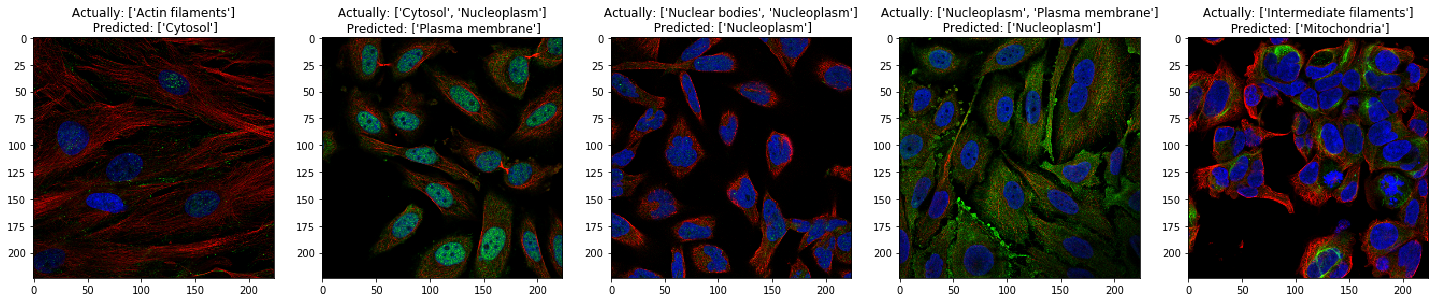

In [73]:
fig , axs = plt.subplots(1,5, figsize = (25,5))
import random
for x in range(5):
    wee = random.randint(0,len(cnn['path']))
    image = datagenerator.load_image(cnn['path'][wee][35:], (224,224,3) )
    axs[x].imshow(image)
    labels = []
    for i in range(28):
        if cnn[str(i)][wee] != float(0):
            labels.append(label_map[i])
    actual = data['Target'][wee]
    act = actual.split(' ')
    clean_label = [label_map[int(t)] for t in act]
    axs[x].set_title(" Actually: {} \n  Predicted: {} ".format(clean_label, labels))
plt.show()